In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from importlib import reload
# import warnings
# warnings.filterwarnings('error')

sys.path[0]=os.path.expandvars('$WORK/Fermi-LAT')

import diffuse, utilities

list(map(reload, (diffuse, utilities)));

In [2]:
from diffuse import cubes;

In [3]:
import healpy
class Polyfit(object):
    """ Manage a log parabola fit to every pixel"""
    def __init__(self, cubefile, sigsfile, start=0, stop=8, deg=2):
        
        m = HealpixCube(cubefile)
        msig = HealpixCube(sigsfile)
        
        meas = np.array([m[i] for i in range(8)])
        sig  = np.array([msig[i] for i in range(8)])

        self.planes = np.array(range(start,stop)) # plane numbers
        self.values = meas[start:,:]
        weights = 100./sig[start:,:] #from percent
        self.wtmean = weights.mean(axis=1)

        self.fit, self.residuals, self.rank, self.svals, self.rcond =\
            np.polyfit(self.planes,self.values, deg=deg, full=True, w=self.wtmean)
            
        labels= 'intercept slope curvature'.split()   
        
    def __getitem__(self, i):
        return self.fit[i]
    
#     def ait_plots(self):
#         self.hpfit=[healpix_map.HParray(labels[deg-i], self.fit[i,:]) for i in range(deg,-1,-1)]
#         healpix_map.multi_ait(self.hpfit, cmap=plt.get_cmap('jet'),  grid_color='grey')

    def __call__(self, x, n):
        if not hasattr(x, '__iter__'):
            x = np.array([x])
        fit= self.fit[:,n]; 
        t =fit.reshape(3,1)
        return ( t * np.vstack([x**2, x, np.ones(len(x))] )).sum(axis=0)
    
    def ang2pix(self, glon, glat):
        return healpy.ang2pix(64, glon, glat, lonlat=True)
        
    def get_fit(self, pix):
             
        y = self.values[:,pix]
        yerr = 1/self.wtmean
        fn = lambda xx : self(xx, pix)
        return y, yerr, fn
    
    def plot_fit(self, glon, glat, ax=None, axis_labels=True):
        pix = self.ang2pix(glon, glat)
        y, yerr, fn = self.get_fit(pix)

        fig, ax =plt.subplots() if ax is None else (ax.figure, ax)
        npl = len(self.planes)
        xx = np.linspace(self.planes[0]-0.5,self.planes[-1]+0.5,2*npl+1)

        ax.errorbar(self.planes, y, yerr=yerr, fmt='o', ms=8);
        ax.plot(xx, fn(xx), '-', lw=2);
        ax.text(0.05,0.9,'({:3.0f}, {:+2.0f})'.format(glon, glat), transform=ax.transAxes)
        if axis_labels:
            ax.set(ylabel='flux factor', xlabel='energy plane')
        ax.axhline(1.0, color='lightgrey')
        ax.grid(alpha=0.3)
        ax.set_xticks(self.planes[::2])  
    
    def multiplot(self, glons, glats, grid_shape=(4,5), title=''):
 
        fig, axx = plt.subplots(grid_shape[0],grid_shape[1], figsize=(12,12), sharex=True, sharey=True,
                            gridspec_kw=dict(left=0.05, right = 0.95,top=0.95, wspace=0, hspace=0)  )
        for glon, glat, ax in zip(glons, glats, axx.flatten()):
            self.plot_fit( glon, glat, ax, axis_labels=False)
        fig.suptitle(title, fontsize=16); 
        fig.set_facecolor('white')

In [5]:
reload(cubes)        
pf = cubes.Polyfit(cubes.bubble_path+'/bubble_cube_v4.fits', cubes.bubble_path+'/bubble_sigmas.fits')

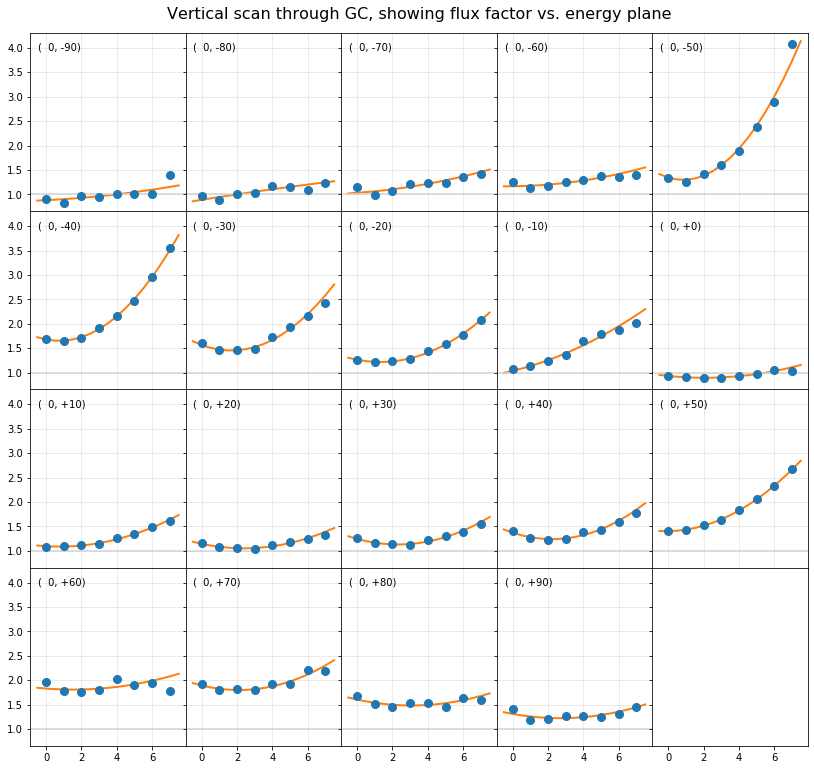

In [6]:
glats = np.linspace(-90,90, 19)
glons = np.zeros(len(glats))
pf.multiplot(glons, glats, title='Vertical scan through GC, showing flux factor vs. energy plane')

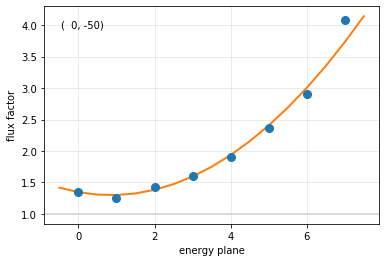

In [9]:
pf.plot_fit(0,-50)